In [12]:
import torch
import numpy as np
from einops import rearrange, repeat, reduce
from utils import display_np_arrays_as_images
display_np_arrays_as_images()

# 说明
einops是一个简洁优雅的张量操作库，支持对numpy、pytorch、tensorflow等库中的张量进行操作，最为常用的是rearrange、repeat和reduce方法
以下内容大多从官方文档而来，自己试一遍加深理解

详细内容见 https://github.com/arogozhnikov/einops

In [ ]:
# 一个普通矩阵
matrix = np.arange(1, 17).reshape((4,4))
matrix

In [6]:
# 首先导入一张图片

image = np.load('test_images.npy', allow_pickle=False)
image
# 原始图片是有六个字母 每个图片96*96 3通道
# 这样的四个维度组成的图片目前无法显示

<array of shape (6, 96, 96, 3)>


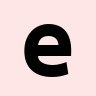

In [7]:
image[0]
# 可以进行单个显示

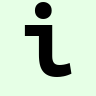

In [8]:
image[1]

## rearrange
rearrange 用于对一个张量内部的维度进行修改变换，可以替换pytorch中的reshape、view、transpose和permute等操作

### 轴的调换
一个张量中 将各个轴进行调换 相当于transpose操作 **表达式上主要将需要调换的轴变为对应顺序即可**

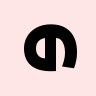

In [13]:
rearrange(image[0], 'h w c -> w h c')
# 将宽和高对调
# 通道不变 将像素维度对调就是对图像沿着左上-右下轴的转置

### 轴的合并
一个张量中 几个轴进行合并为一个 最为主要用到的表达式是括号() **通过用()将需要合并的轴统一为一个, 同时中间的维度可以互相替换位置**

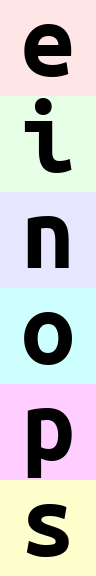

In [10]:
# 对两个维度进行合并
rearrange(image, 'b h w c -> (b h) w c')
# 将batch和height进行合并为 新的height轴 高度变为六倍 宽度不变

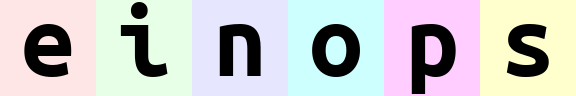

In [11]:
rearrange(image, 'b h w c -> h (b w) c')
# 这个表达式包括了转置和合并，先将height轴放在第一维 而后将batch和width合并 得到的就是高度不变 长度为六倍的图

In [20]:
rearrange(image, 'b h w c -> (b h w c)').shape
# 合并可以在多个维度上合并 全合并相当于flatten

(165888,)

### 轴的分解
将一个轴分解为多个子轴，使用括号进行实现 **具体操作为表达式左侧为原始维度个数，但是要分解的轴用括号和子轴表示，右侧为分解后的结果，参数值中包括能够推理出各个维度的数值**

In [22]:
rearrange(image, '(b1 b2) h w c -> b1 b2 h w c', b1=2).shape
# 将第一个维度分解为b1 b2 且参数b1为2 b2就可以推理得出

(2, 3, 96, 96, 3)

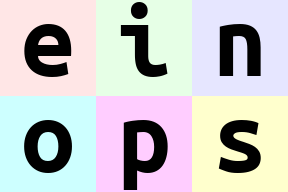

In [24]:
rearrange(image, '(b1 b2) h w c -> (b1 h) (b2 w) c', b1=2)
# 在分解和同样可以结合轴合并 上述过程为分解后 2个高度 3个宽度进行排列
# 先按照宽度排列 再按照高度排列

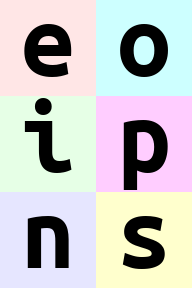

In [45]:
rearrange(image, '(b1 b2) h w c -> (b2 h) (b1 w) c', b1=2)
# 在分解和同样可以结合轴合并 上述过程为分解后 2个高度 3个宽度进行排列
# 先按照宽度排列 再按照高度排列

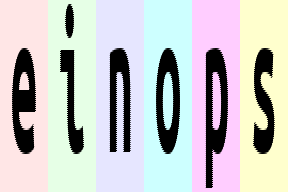

In [47]:
# 通过轴分解与合并将宽度的一半维度分给高度
# 表达式左侧是将宽度分为两半
# 右侧比较复杂 (b w)表示每次取原来一半的width个 每次取batch个
# (h w2)代表每2个放一组 放h组
rearrange(image, 'b h (w w2) c -> (h w2) (b w) c', w2=2)

### 轴的顺序
对于维度上的分解与合并而言，括号中的顺序也是十分重要的，即便括号中最终乘法计算的维度结果相同，但是顺序不同则数据排布即不同。
在括号中，越靠左边的数字最关键，确定了取值的基本单元

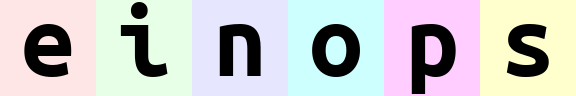

In [40]:
# 若采用先batch再width的表示 在每一行(height轴)上 每次取一个图像宽，取batch个组成了一行，那么就是einops的各个图像每个取一个 组成了最终的第一行
rearrange(image, 'b h w c -> h (b w) c')

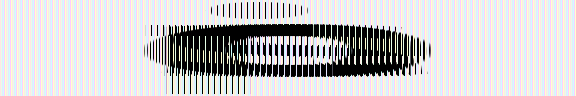

In [41]:
# 先width再batch则是 在每一行 每个batch取一个点 取width次， 那么就导致了字母i最上方 每次只隔着五个像素才能有一个白色值
rearrange(image, 'b h w c -> h (w b) c')

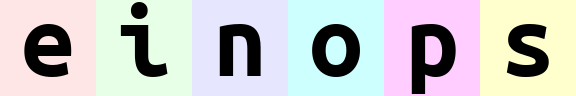

In [49]:
# 对batch进行分割 首先 (b1 b2)表示 意思为每次取3个 总共有2组 第一组为ein 第二组为ops
# 若以b1 b2 w表示 则为一行中的数据：每次取一行 每3个为一组 每2个再为一组 即为einops
rearrange(image, '(b1 b2) h w c -> h (b1 b2 w) c', b1=2, b2=3)

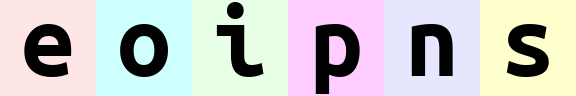

In [51]:
# 此时以b2 b1 w表示 则为一行数据中：先按照b1轴取两个 共3组 那么就是e和o一组 i和p椅子 n和s一组
rearrange(image, '(b1 b2) h w c -> h (b2 b1 w) c', b1=2, b2=3)

### 增加或删除一个1轴
类似于squeeze和unsqueeze rearrange能够增加一个空维度或删除空维度

In [65]:
x = rearrange(image, 'b h w c -> b 1 h w 1 c')
x.shape

(6, 1, 96, 96, 1, 3)

In [66]:
y = rearrange(x, 'b 1 h w 1 c -> b h w c')
y.shape

(6, 96, 96, 3)

## reduce
reduce的作用是沿着某个轴进行计算 平均值、最大值、最小值等等。reduce作用的轴会消失即维度变小

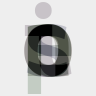

In [52]:
reduce(image, 'b h w c -> h w c', 'mean')
# 对batch轴进行平均值计算 b轴消失

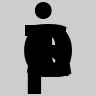

In [53]:
reduce(image, 'b h w c -> h w', 'min')
# 对batch和channel轴进行最小值计算 由于黑色最小 则原始图中黑色部分都显示出来

In [57]:
image.shape

(6, 96, 96, 3)

In [62]:
rearrange(image, 'b (h h2) (w w2) c -> (b h w h2) w2 c', h2=2, w2=2)
# 首先这是对整个图片切成2*2的块 按照每个字母从左到右从上到下摆放

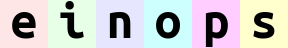

In [54]:
reduce(image, 'b (h h2) (w w2) c -> h (b w) c', 'mean', h2=2, w2=2)
# 首先对height和width轴进行切分 就是上述情况 每个子块有2*2大小
# 切分之后在消失的h2 w2两个轴上进行均值操作 生成一个值
# 然后按照h (b w) c的情况进行排列
# 本质上就实现了平均池化

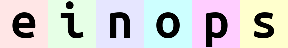

In [64]:
reduce(image, 'b (h h2) (w w2) c -> h (b w) c', 'max', h2=2, w2=2)
# 最大池化

## repeat
repeat方法对数据创建一个新轴 并重复任意次数

In [67]:
# repeat将宽度重复五次
repeat(image[0], 'h w c -> h new_axis w c', new_axis=5).shape

(96, 5, 96, 3)

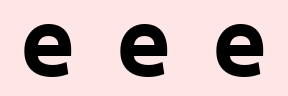

In [68]:
repeat(image[0], 'h w c -> h (repeat_num w) c', repeat_num=3)
# 对宽度重复3次

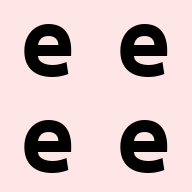

In [69]:
repeat(image[0], 'h w c -> (2 h) (2 w) c')
# 对高和宽重复两次

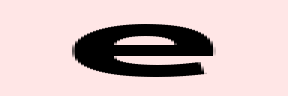

In [70]:
# 重复的顺序也有区别
repeat(image[0], 'h w c -> h (w 3) c')
# 这是每个像素点重复3次 对width每个都执行一遍

## 作为层对象存在


In [71]:
from einops.layers.torch import Rearrange, Reduce

In [72]:
layer = Rearrange('b h w c -> b (h w c)')
# 一个简单的flatten层

In [73]:
type(layer)

einops.layers.torch.Rearrange

In [74]:
input_ = torch.randn(size=(10, 32, 32, 3))

In [75]:
output = layer(input_)

In [76]:
output.shape

torch.Size([10, 3072])